# Similar Boroughs of Istanbul

                                                          Studied by Vedat Ozkan

## 1. Introduction

In this study, I target to practice K-means clustering of Unsupervised Machine Learning models. Actually, alltough I performed similar study earlier, our business problem will be different this time. My basic goal will determine similar boroughs of Istanbul that is one of famous and also crowded cities in the world. We will make this comparision by Foursquare data.

Besides, my futher goal will be a webpage providing same service for all countries and cities. Thus any user can select to different locations and then will be able to see similar neighborhoods easily.

## 2. Business Problem

In this study, it will be strived to determine similar boroughs of Istanbul to each other using Foursquare data.


## 3. Data Description

Data will be required below: \
   a. List of neighborhoods of Istanbul \
   b. Geographic coordination of neighborhoods \
   c. List of Venues and theirlocations in Istanbul


## 4. Methodology

1.Istanbul neighborhood will be listed.\
2.Geographic coordination will be ingested using ArcGIS and concatenated to the 3.Istanbul neighborhood list.\
4.The locations of neighborhoods will be displayed on the map.\
5.Venues in Istanbul will be ingested using Foursquare API with their locations and coordination.\
6.The Venues will be reorganized by their categories and reordered by averages of densities.\
7.The top 10 venue categories will be selected by Istanbul boroughs for further operations.\
8.It will be encoded for the Machine Learning application.\
9.It will be determined the number of clusters using the Elbow Method.\
10.K-Means model will be applied to the dataset.\
11.Predicted labels will be inserted into the dataset.\
12.Borough clusters of Istanbul will be visualized on the map by their segmentation.\
13.All boroughs will be listed with their venue categories to interpret.\



In [ ]:
!pip install arcgis

  Using cached https://files.pythonhosted.org/packages/83/d6/30aed7ef13ff3f359e99626c1b0a32ebbc3bf9b9d5616ec46e9e245d5fa9/jupyter_client-6.1.11-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c5/8f/51e89ce52a085483359217bc72cdbf6e75ee595d5b1d4b5ade40c7e018b8/jsonschema-3.2.0-py2.py3-none-any.whl
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


In [ ]:
import pandas as pd
import requests as re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# import k-means for the clustering stage
from sklearn.cluster import KMeans
# web scrapping
from bs4 import BeautifulSoup as bs
# show all rows
pd.set_option('display.max_rows',None)
# ArcGIS 
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()
# ignore warnings
import warnings
warnings.filterwarnings("ignore")





### Neighborhoods if Istanbul

- Data Collection

In [ ]:
url_IstanbulNeighborhoods = "https://www.atlasbig.com/tr/istanbulun-mahalleleri"
Tr2Eng = str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU")

def getdata(url):
  data = re.get(url)
  data = pd.read_html(data.text)[0]
  data.columns=["neighborhood","borough","population","area"]
  data = data.drop(["population","area"], axis=1)
  for i in data[["neighborhood","borough"]]:
    for j in range(len(data[i])):
      data[i][j] = data[i][j].replace(data[i][j], data[i][j].encode('latin1').decode('utf8'))
      data[i][j] = data[i][j].translate(Tr2Eng)
  return data

df = getdata(url_IstanbulNeighborhoods)
print(df.shape)
df.head()

(828, 2)


,neighborhood,borough
0,Atakent,Kucukcekmece
1,Adnan Kahveci,Beylikduzu
2,Zafer,Bahcelievler
3,Zumrutevler,Maltepe
4,Halkali Merkez,Kucukcekmece


### Geographic Coordinations of Istanbul Neighborhoods

In [ ]:
#geocode( "34684,Tufan Mahallesi, Uskudar, Istanbul, Turkey, TUR")[0]

In [ ]:
def coordinations(borough, neighborhood=np.nan):
   latitude = 0
   longtitude = 0
   g = geocode(address='{}, İstanbul, Turkey, TR'.format(neighborhood, borough))[0]
   longtitude = g['location']['x']
   latitude = g['location']['y']
   data_geocoded = [neighborhood,borough, latitude, longtitude]   
   return data_geocoded

ist_coords =[]

for borough,neighborhood in zip(df["borough"], df["neighborhood"]):
  ist_coords.append( coordinations(borough, neighborhood)) 

df_geocoded = pd.DataFrame(ist_coords, columns=["neighborhood", "borough", "latitude", "longtitude"])
df_geocoded.head()

,neighborhood,borough,latitude,longtitude
0,Atakent,Kucukcekmece,41.01860,29.10918
1,Adnan Kahveci,Beylikduzu,41.01122,28.63006
2,Zafer,Bahcelievler,41.30081,28.67763
3,Zumrutevler,Maltepe,40.93436,29.14225
4,Halkali Merkez,Kucukcekmece,41.03739,28.79682


### Neighborhood Map of Istanbul

In [ ]:
istanbul = geocode(address='İstanbul, Turkey, TR')[0]
istanbul_longtitude = istanbul['location']['x']
istanbul_latitude = istanbul['location']['y']
print(istanbul_latitude, istanbul_longtitude)

41.01384000000007 28.94966000000005


In [ ]:
map_ist = folium.Map(location=[istanbul_latitude,istanbul_longtitude], zoom_start=10)
map_ist

# adding markers to map
for neighbor, borough, lat, long in zip(df_geocoded['neighborhood'], df_geocoded['borough'], df_geocoded['latitude'], df_geocoded['longtitude']):
    label = '{}, {}'.format(neighbor, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, long],
                        radius=5,
                        popup=label,
                        color='red',  
                        fill=True).add_to(map_ist)
    
map_ist

### Venues in Istanbul



Defining a function to get the neraby venues in the neighbourhood. This will help us get venue categories which is important for our analysis


In [ ]:
CLIENT_ID = 'GOFFY40O53ULUMR3XJ0AGJ02U42XM3GHMTKDCJSRTZTAL2MD' 
CLIENT_SECRET = 'AQGJXCZ2DGDXYYUCUP14LHC2U0NN3F5412CI1CKB3TCBT01X'
VERSION = '20210101' # Foursquare API version

In [ ]:
venues_list=[]
RADIUS=500
LIMIT=50

for borough, lat, long in zip(df_geocoded["borough"], df_geocoded["latitude"], df_geocoded["longtitude"]):
  url_foursquare = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                                         CLIENT_SECRET,
                                                                                                                                         VERSION,
                                                                                                                                         lat,
                                                                                                                                         long, 
                                                                                                                                         RADIUS, 
                                                                                                                                         LIMIT)                                                                                                                                                                                                                               
                                                                                                                  
  results = re.get(url_foursquare).json()["response"]['groups'][0]['items']

  for v in results:
    venues_list.append([borough, lat, long, v["venue"]["name"], v["venue"]["categories"][0]["name"]])

  


In [ ]:
len(venues_list)

24845

In [ ]:
venues_list[0]

['Kucukcekmece',
 41.01860000000005,
 29.109180000000038,
 'Kibrit Lounge',
 'Café']

In [ ]:
venues_df = pd.DataFrame(venues_list, columns = ['Borough', 'Latitude','Longitude', 'Venue', 'Category'])
print(venues_df.shape)                                                                                            
venues_df.head()

(24845, 5)


,Borough,Latitude,Longitude,Venue,Category
0,Kucukcekmece,41.0186,29.10918,Kibrit Lounge,Café
1,Kucukcekmece,41.0186,29.10918,Misaki Milli Korusu,Park
2,Kucukcekmece,41.0186,29.10918,Dippoint,Café
3,Kucukcekmece,41.0186,29.10918,Mola Art,Café
4,Kucukcekmece,41.0186,29.10918,Gratis,Cosmetics Shop


Grouping Venue Category

In [ ]:
print(venues_df.groupby("Category").max().shape)
venues_df.groupby("Category").max().head()

(489, 4)


,Borough,Latitude,Longitude,Venue
Category,,,,
ATM,Tuzla,41.05162,29.32218,YKB ATM Velibaba
Accessories Store,Sile,41.16768,29.61071,Zargun Takı Tasarım Mağaza
Adult Boutique,Kadikoy,40.97424,29.04400,Edwards Kalamis
Adult Education Center,Sariyer,41.11503,29.02299,BT Eğitim
Advertising Agency,Kadikoy,41.06311,29.04400,sekizpiksel iletişim ajansı ve yapım stüdyosu


One Hot Encoding

We have 428 different venue categories in Istanbul. Now we need to apply Encoding before clustering

In [ ]:
ist_venue_cat = pd.get_dummies(venues_df['Category'], prefix="", prefix_sep="")
len(ist_venue_cat.columns)

489

Now let's prefix venue_df["Neighborhood"] to ist_venue_cat

In [ ]:
ist_venue_cat["Borough"] = venues_df["Borough"]
len(ist_venue_cat.columns)

# ist_venue_cat.columns.get_loc("Neighborhood")

490

In [ ]:
# make neighborhood column to the first column

fixed_columns = [ist_venue_cat.columns[-1]] + list(ist_venue_cat.columns[:-1])
len(fixed_columns)

490

In [ ]:
ist_venue_cat = ist_venue_cat[fixed_columns]
ist_venue_cat.head()

,Borough,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,...,Thrift / Vintage Store,Toll Booth,Toll Plaza,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Trailer Park,Train Station,Tram Station,Travel Agency,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,Urgent Care Center,Vape Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Village,Vineyard,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,Kucukcekmece,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kucukcekmece,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kucukcekmece,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kucukcekmece,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kucukcekmece,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Venue categories mean value

We will group the Neighbourhoods and calculate the mean venue categories value in each Neighbourhood


In [ ]:
ist_neighborhood_grouped = ist_venue_cat.groupby('Borough').mean().reset_index()
ist_neighborhood_grouped.head()

,Borough,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,...,Thrift / Vintage Store,Toll Booth,Toll Plaza,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Trailer Park,Train Station,Tram Station,Travel Agency,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,Urgent Care Center,Vape Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Village,Vineyard,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,Arnavutkoy,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.002457,0.002457,0.002457,0.0,0.0,0.000000,0.0,0.000000,0.004914,0.0,0.004914,0.002457,0.0,0.000000,0.000000,0.000000,0.002457,0.000000,0.0,0.000000,0.009828,0.000000,0.000000,0.002457,0.000000,0.004914,0.014742,0.002457,0.004914,0.002457,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.002457,0.024570,0.0,0.0,0.0,0.000000,0.0,0.0,0.002457,0.002457,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.002457,0.002457,0.000000,0.0,0.000000
1,Avcilar,0.002959,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.002959,0.0,0.000000,0.011834,0.0,0.002959,0.000000,0.0,0.002959,0.002959,0.000000,0.002959,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.002959,0.000000,0.002959,0.017751,0.023669,0.002959,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.002959,0.000000,0.005917,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.002959,0.011834,0.0,0.0,0.0,0.002959,0.0,0.0,0.002959,0.000000,0.0,0.0,0.0,0.000000,0.005917,0.002959,0.0,0.0,0.000000,0.0,0.005917,0.000000,0.002959,0.0,0.000000
2,Bagcilar,0.000000,0.003419,0.0,0.0,0.0,0.001709,0.0,0.0,0.001709,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.001709,0.013675,0.0,0.001709,0.000000,0.0,0.001709,0.001709,0.000000,0.003419,0.000000,0.0,0.001709,0.000000,0.001709,0.001709,0.001709,0.000000,0.005128,0.017094,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.001709,0.001709,0.0,0.001709,0.001709,0.0,0.001709,0.0,0.0,0.000000,0.047863,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.003419,0.000000,0.0,0.0,0.001709,0.0,0.005128,0.005128,0.000000,0.0,0.000000
3,Bahcelievler,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.011834,0.0,0.005917,0.000000,0.0,0.005917,0.002959,0.002959,0.002959,0.002959,0.0,0.000000,0.005917,0.000000,0.000000,0.002959,0.000000,0.002959,0.026627,0.002959,0.005917,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.002959,0.000000,0.008876,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.014793,0.068047,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.008876,0.000000,0.000000,0.0,0.002959
4,Bakirkoy,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.001718,0.0,0.0,0.000000,0.0,0.001718,0.001718,0.0,0.012027,0.000000,0.0,0.006873,0.000000,0.000000,0.017182,0.000000,0.0,0.000000,0.000000,0.000000,0.001718,0.006873,0.001718,0.001718,0.041237,0.001718,0.000000,0.005155,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.003436,0.001718,0.0,0.005155,0.000000,0.0,0.001718,0.0,0.0,0.003436,0.042955,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.003436,0.000000,0.001718,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.005155,0.0,0.000000


### Top 10 Categories 

Since there are too many categories, we had better take the top 10 for clustering.


In [ ]:

top10_cat_list = []

for each in np.arange(len(ist_neighborhood_grouped)):
  print(ist_neighborhood_grouped.iloc[each][0])
  print(list(pd.DataFrame(ist_neighborhood_grouped.iloc[each,1:].sort_values(ascending=False, axis=0)[:11]).T.columns))
  top10_cat_list.append(list(pd.DataFrame(ist_neighborhood_grouped.iloc[each,1:].sort_values(ascending=False, axis=0)[:10]).T.columns))    
                                                                                   
                                                                                                               

Arnavutkoy
['Café', 'Park', 'Plaza', 'Restaurant', 'Convenience Store', 'Turkish Restaurant', 'Big Box Store', 'Diner', 'Soccer Field', 'Shopping Mall', 'Garden']
Avcilar
['Café', 'Coffee Shop', 'Hotel', 'Gym', 'Restaurant', 'Bar', 'Dessert Shop', 'Kebab Restaurant', 'Pizza Place', 'Tea Room', 'Shopping Mall']
Bagcilar
['Café', 'Turkish Restaurant', 'Electronics Store', 'Restaurant', 'Steakhouse', 'Pizza Place', 'Gym', 'Park', 'Clothing Store', 'Gym / Fitness Center', 'Dessert Shop']
Bahcelievler
['Café', 'Turkish Restaurant', 'Gym', 'Gym / Fitness Center', 'Tea Room', 'Steakhouse', 'Bakery', 'Breakfast Spot', 'Restaurant', 'Pizza Place', 'Dessert Shop']
Bakirkoy
['Café', 'Restaurant', 'Coffee Shop', 'Turkish Restaurant', 'Bakery', 'Seafood Restaurant', 'Gym', 'Fast Food Restaurant', 'Park', 'Dessert Shop', 'Kebab Restaurant']
Basaksehir
['Café', 'Steakhouse', 'Shopping Mall', 'Gym', 'Restaurant', 'Dessert Shop', 'Fast Food Restaurant', 'Furniture / Home Store', 'Kebab Restaurant', 'De

In [ ]:

col_names =[]
num_top_venues = 10

indicator=["st","nd","rd"]

for col in np.arange(num_top_venues):
  try:
    print("{}{} most common venue".format(col+1, indicator[col]))
    col_names.append("{}{} most common venue".format(col+1, indicator[col]))
  except:
    print("{}th most common venue".format(col+1))
    col_names.append("{}th most common venue".format(col+1))

1st most common venue
2nd most common venue
3rd most common venue
4th most common venue
5th most common venue
6th most common venue
7th most common venue
8th most common venue
9th most common venue
10th most common venue


In [ ]:
ist_top10_cat = pd.DataFrame(top10_cat_list, columns =col_names)

ist_top10_cat.head()

,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Café,Park,Plaza,Restaurant,Convenience Store,Turkish Restaurant,Big Box Store,Diner,Soccer Field,Shopping Mall
1,Café,Coffee Shop,Hotel,Gym,Restaurant,Bar,Dessert Shop,Kebab Restaurant,Pizza Place,Tea Room
2,Café,Turkish Restaurant,Electronics Store,Restaurant,Steakhouse,Pizza Place,Gym,Park,Clothing Store,Gym / Fitness Center
3,Café,Turkish Restaurant,Gym,Gym / Fitness Center,Tea Room,Steakhouse,Bakery,Breakfast Spot,Restaurant,Pizza Place
4,Café,Restaurant,Coffee Shop,Turkish Restaurant,Bakery,Seafood Restaurant,Gym,Fast Food Restaurant,Park,Dessert Shop


In [ ]:
ist_neighborhood_grouped["Borough"]

0        Arnavutkoy
1           Avcilar
2          Bagcilar
3      Bahcelievler
4          Bakirkoy
5        Basaksehir
6        Bayrampasa
7          Besiktas
8            Beykoz
9        Beylikduzu
10          Beyoglu
11     Buyukcekmece
12         Cekmekoy
13          Esenler
14         Esenyurt
15             Eyup
16            Fatih
17    Gaziosmanpasa
18         Gungoren
19          Kadikoy
20        Kagithane
21           Kartal
22     Kucukcekmece
23          Maltepe
24           Pendik
25       Sancaktepe
26          Sariyer
27             Sile
28            Sisli
29      Sultanbeyli
30       Sultangazi
31            Tuzla
32         Umraniye
33          Uskudar
34      Zeytinburnu
Name: Borough, dtype: object

In [ ]:
ist_top10_cat["borough"] = ist_neighborhood_grouped["Borough"]
ist_top10_cat.head()

,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,borough
0,Café,Park,Plaza,Restaurant,Convenience Store,Turkish Restaurant,Big Box Store,Diner,Soccer Field,Shopping Mall,Arnavutkoy
1,Café,Coffee Shop,Hotel,Gym,Restaurant,Bar,Dessert Shop,Kebab Restaurant,Pizza Place,Tea Room,Avcilar
2,Café,Turkish Restaurant,Electronics Store,Restaurant,Steakhouse,Pizza Place,Gym,Park,Clothing Store,Gym / Fitness Center,Bagcilar
3,Café,Turkish Restaurant,Gym,Gym / Fitness Center,Tea Room,Steakhouse,Bakery,Breakfast Spot,Restaurant,Pizza Place,Bahcelievler
4,Café,Restaurant,Coffee Shop,Turkish Restaurant,Bakery,Seafood Restaurant,Gym,Fast Food Restaurant,Park,Dessert Shop,Bakirkoy


In [ ]:

fixed_columns = [ist_top10_cat.columns[-1]] + list(ist_top10_cat.columns[:-1])
ist_top10_cat = ist_top10_cat[fixed_columns]

ist_top10_cat

,borough,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Arnavutkoy,Café,Park,Plaza,Restaurant,Convenience Store,Turkish Restaurant,Big Box Store,Diner,Soccer Field,Shopping Mall
1,Avcilar,Café,Coffee Shop,Hotel,Gym,Restaurant,Bar,Dessert Shop,Kebab Restaurant,Pizza Place,Tea Room
2,Bagcilar,Café,Turkish Restaurant,Electronics Store,Restaurant,Steakhouse,Pizza Place,Gym,Park,Clothing Store,Gym / Fitness Center
3,Bahcelievler,Café,Turkish Restaurant,Gym,Gym / Fitness Center,Tea Room,Steakhouse,Bakery,Breakfast Spot,Restaurant,Pizza Place
4,Bakirkoy,Café,Restaurant,Coffee Shop,Turkish Restaurant,Bakery,Seafood Restaurant,Gym,Fast Food Restaurant,Park,Dessert Shop
5,Basaksehir,Café,Steakhouse,Shopping Mall,Gym,Restaurant,Dessert Shop,Fast Food Restaurant,Furniture / Home Store,Kebab Restaurant,Department Store
6,Bayrampasa,Café,Turkish Restaurant,Park,Hotel,Bakery,Restaurant,Dessert Shop,Gym / Fitness Center,Gym,Electronics Store
7,Besiktas,Café,Coffee Shop,Park,Restaurant,Dessert Shop,Turkish Restaurant,Gym,Hotel,Gym / Fitness Center,Bakery
8,Beykoz,Café,Seafood Restaurant,Restaurant,Breakfast Spot,Turkish Restaurant,Plaza,Hotel,Park,Coffee Shop,Steakhouse
9,Beylikduzu,Café,Restaurant,Bakery,Turkish Restaurant,Steakhouse,Coffee Shop,Dessert Shop,Park,Arcade,Fast Food Restaurant


### Model Building

#### K Means



We use the K Means clustering technique to do so. But we need to determine number of clusters(k) . Elbow Method is a method to determine k value.

In [ ]:
# Drop categorical data: ist_neighborhood_grouped["Borough"]

ist_neighborhood_clustering = ist_neighborhood_grouped.drop("Borough", axis =1)


### Elbow Method

In [ ]:
distortions = []

K_values = range(1,10)

for k in K_values:
  kmeanModel = KMeans(n_clusters=k, random_state=0).fit(ist_neighborhood_clustering)
  distortions.append(kmeanModel.inertia_)

distortions                                                                                              

[0.16853150989782525,
 0.13893993949163724,
 0.1224753037153424,
 0.11186562044607551,
 0.09836006341765043,
 0.09046427556560574,
 0.08567390165712178,
 0.07469174174043952,
 0.06966799329998141]

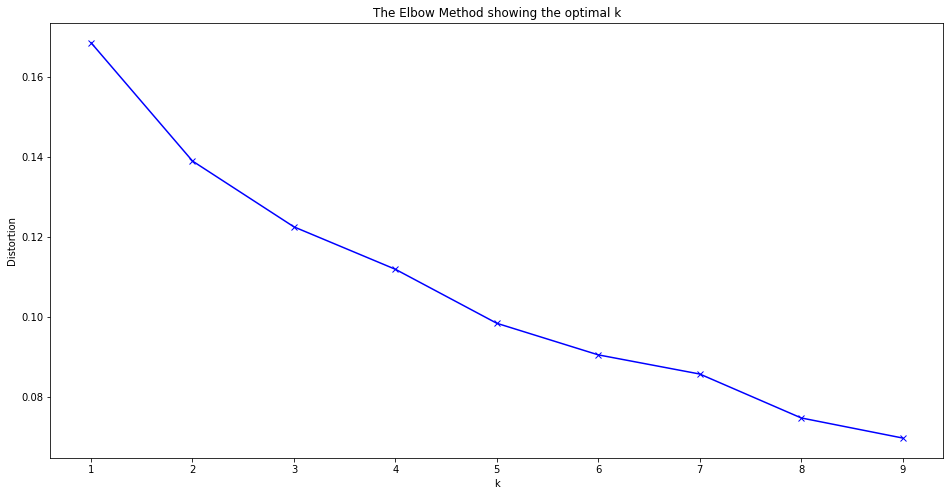

In [ ]:
 # Let's plot the dissortations of K-Means 
 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K_values, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# There is not an elbow point. It means model cannot find centroids of clusters. We can think of using other clustering models.
# However I will continue to complete KNN study, and I will take 5 as number of clustering (k)

kmeans_ist =  KMeans(n_clusters=5, random_state=0).fit(ist_neighborhood_clustering)
kmeans_ist

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

#### Labelling Clustered Data

In [ ]:
# Let's see labels of Istanbul boroughs
kmeans_ist.labels_

array([1, 3, 3, 1, 0, 1, 1, 0, 4, 3, 2, 1, 3, 1, 3, 1, 2, 3, 1, 0, 1, 3, 3, 3, 1, 3, 4, 4, 0, 3, 3, 1, 3, 3, 1],
      dtype=int32)

In [ ]:
# Let's insert labels into our final "ist_top10_cat" table. It is better  to add 1 all labels not to see 0.

ist_top10_cat.insert(loc=0, column="cluster label", value = kmeans_ist.labels_ +1)

In [ ]:
# Let's merge geographic coordinations of borough and  "ist_top10_cat" as well

def borough_coordinations(borough):
   latitute = 0
   longtitute = 0
   g = geocode(address='{}, İstanbul, Turkey, TR'.format(borough))[0]
   longtitute = g['location']['x']
   latitute = g['location']['y']
   coords = [borough, latitute, longtitute]
   return coords


borough_coords_list = []

for i in ist_neighborhood_grouped["Borough"]:
  borough_coords_list.append(borough_coordinations(i))


borough_coords = pd.DataFrame(borough_coords_list, columns=[ "borough", "latitude", "longtitude"])

print(borough_coords.shape)
borough_coords.head()

(35, 3)


,borough,latitude,longtitude
0,Arnavutkoy,41.18558,28.74147
1,Avcilar,40.97813,28.72101
2,Bagcilar,41.03323,28.86351
3,Bahcelievler,40.99805,28.84737
4,Bakirkoy,40.98273,28.87480


In [ ]:
istanbul_venues = pd.merge(borough_coords, ist_top10_cat, on="borough", how="inner")
istanbul_venues.head()

,borough,latitude,longtitude,cluster label,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Arnavutkoy,41.18558,28.74147,2,Café,Park,Plaza,Restaurant,Convenience Store,Turkish Restaurant,Big Box Store,Diner,Soccer Field,Shopping Mall
1,Avcilar,40.97813,28.72101,4,Café,Coffee Shop,Hotel,Gym,Restaurant,Bar,Dessert Shop,Kebab Restaurant,Pizza Place,Tea Room
2,Bagcilar,41.03323,28.86351,4,Café,Turkish Restaurant,Electronics Store,Restaurant,Steakhouse,Pizza Place,Gym,Park,Clothing Store,Gym / Fitness Center
3,Bahcelievler,40.99805,28.84737,2,Café,Turkish Restaurant,Gym,Gym / Fitness Center,Tea Room,Steakhouse,Bakery,Breakfast Spot,Restaurant,Pizza Place
4,Bakirkoy,40.98273,28.87480,1,Café,Restaurant,Coffee Shop,Turkish Restaurant,Bakery,Seafood Restaurant,Gym,Fast Food Restaurant,Park,Dessert Shop


## Visualizing the clustered neighbourhood

In [ ]:
map_istanbul_clusters = folium.Map(location=[istanbul_latitude,istanbul_longtitude], zoom_start=12)

k_num_clusters =5

# set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0,1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_venues['latitude'], istanbul_venues['longtitude'], istanbul_venues['borough'], istanbul_venues['cluster label']):
  label = folium.Popup('Cluster ' + str(int(cluster)) + '\n' + str(poi) , parse_html=True)
  folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster-2)],
        fill=True,
        fill_color=rainbow[int(cluster-2)]
        ).add_to(map_istanbul_clusters)
        
map_istanbul_clusters

Cluster Label 1

In [ ]:
istanbul_venues[istanbul_venues["cluster label"]==1]

,borough,latitude,longtitude,cluster label,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
4,Bakirkoy,40.98273,28.87480,1,Café,Restaurant,Coffee Shop,Seafood Restaurant,Turkish Restaurant,Bakery,Gym,Fast Food Restaurant,Dessert Shop,Kebab Restaurant
7,Besiktas,41.04190,29.00575,1,Café,Coffee Shop,Restaurant,Park,Turkish Restaurant,Dessert Shop,Gym,Hotel,Gym / Fitness Center,Bakery
19,Kadikoy,40.98867,29.02732,1,Café,Coffee Shop,Restaurant,Bakery,Park,Gym / Fitness Center,Dessert Shop,Turkish Restaurant,Seafood Restaurant,Kebab Restaurant
26,Sariyer,41.15998,29.04180,1,Café,Seafood Restaurant,Restaurant,Turkish Restaurant,Coffee Shop,Gym,Breakfast Spot,Park,Pizza Place,Bakery
28,Sisli,41.06201,28.98877,1,Café,Coffee Shop,Hotel,Turkish Restaurant,Restaurant,Bakery,Dessert Shop,Breakfast Spot,Gym / Fitness Center,Kebab Restaurant


Cluster Label 2

In [ ]:
istanbul_venues[istanbul_venues["cluster label"]==2]

,borough,latitude,longtitude,cluster label,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
3,Bahcelievler,40.99805,28.84737,2,Café,Turkish Restaurant,Gym / Fitness Center,Gym,Steakhouse,Tea Room,Bakery,Breakfast Spot,Fast Food Restaurant,Pizza Place
6,Bayrampasa,41.04381,28.91214,2,Café,Turkish Restaurant,Hotel,Park,Restaurant,Bakery,Gym,Gym / Fitness Center,Dessert Shop,Electronics Store
8,Beykoz,41.12647,29.09741,2,Café,Seafood Restaurant,Restaurant,Turkish Restaurant,Breakfast Spot,Park,Plaza,Bakery,Hotel,Coffee Shop
11,Buyukcekmece,41.02046,28.58729,2,Café,Turkish Restaurant,Restaurant,Steakhouse,Bakery,Breakfast Spot,Park,Gym,Arcade,Fast Food Restaurant
13,Esenler,41.03932,28.88115,2,Café,Turkish Restaurant,Gym,Gym / Fitness Center,Electronics Store,Seafood Restaurant,Clothing Store,Arcade,Coffee Shop,Bakery
15,Eyup,41.05877,28.92305,2,Café,Turkish Restaurant,Bakery,Park,Dessert Shop,Restaurant,Gym,Coffee Shop,Seafood Restaurant,Breakfast Spot
18,Gungoren,41.02205,28.87828,2,Turkish Restaurant,Café,Coffee Shop,Dessert Shop,Gym,Clothing Store,Gym / Fitness Center,Restaurant,Bakery,Tea Room
20,Kagithane,41.08011,28.97332,2,Café,Turkish Restaurant,Gym,Restaurant,Gym / Fitness Center,Clothing Store,Fast Food Restaurant,Park,Breakfast Spot,Pizza Place
31,Tuzla,40.81753,29.30411,2,Café,Turkish Restaurant,Steakhouse,Restaurant,Seafood Restaurant,Park,Dessert Shop,Bakery,Clothing Store,Kebab Restaurant
34,Zeytinburnu,40.99526,28.90170,2,Café,Turkish Restaurant,Restaurant,Dessert Shop,Coffee Shop,Gym / Fitness Center,Breakfast Spot,Fast Food Restaurant,Gym,Ice Cream Shop


Cluster Label 3

In [ ]:
istanbul_venues[istanbul_venues["cluster label"]==3]

,borough,latitude,longtitude,cluster label,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
10,Beyoglu,41.03672,28.98612,3,Hotel,Café,Restaurant,Turkish Restaurant,Art Gallery,Coffee Shop,Dance Studio,Bar,Dessert Shop,Plaza
16,Fatih,41.01958,28.94726,3,Café,Hotel,Turkish Restaurant,Restaurant,Mosque,Kebab Restaurant,Dessert Shop,Historic Site,Coffee Shop,Jewelry Store


Cluster Label 4

In [ ]:
istanbul_venues[istanbul_venues["cluster label"]==4]

,borough,latitude,longtitude,cluster label,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
1,Avcilar,40.97813,28.72101,4,Café,Coffee Shop,Hotel,Restaurant,Gym,Dessert Shop,Bar,Pizza Place,Breakfast Spot,Tea Room
2,Bagcilar,41.03323,28.86351,4,Café,Turkish Restaurant,Electronics Store,Restaurant,Steakhouse,Pizza Place,Park,Gym,Gym / Fitness Center,Bakery
5,Basaksehir,41.10745,28.80061,4,Café,Steakhouse,Restaurant,Fast Food Restaurant,Bakery,Dessert Shop,Gym,Kebab Restaurant,Turkish Restaurant,Shopping Mall
9,Beylikduzu,41.00579,28.65930,4,Café,Bakery,Restaurant,Turkish Restaurant,Steakhouse,Coffee Shop,Dessert Shop,Park,Fast Food Restaurant,Gym
12,Cekmekoy,41.03290,29.17383,4,Café,Steakhouse,Restaurant,Turkish Restaurant,Pool,Seafood Restaurant,Gym,Gym / Fitness Center,Park,Bakery
14,Esenyurt,41.03246,28.66093,4,Café,Restaurant,Turkish Restaurant,Steakhouse,Gym,Clothing Store,Bakery,Convenience Store,Park,Gym / Fitness Center
17,Gaziosmanpasa,41.05728,28.91605,4,Café,Turkish Restaurant,Gym,Restaurant,Bakery,Electronics Store,Fast Food Restaurant,Clothing Store,Steakhouse,Kebab Restaurant
21,Kartal,40.89064,29.19082,4,Café,Turkish Restaurant,Fast Food Restaurant,Restaurant,Bakery,Bar,Gym,Steakhouse,Park,Arcade
22,Kucukcekmece,40.99672,28.77586,4,Café,Turkish Restaurant,Park,Gym / Fitness Center,Restaurant,Dessert Shop,Bakery,Breakfast Spot,Gym,Steakhouse
23,Maltepe,40.92496,29.13087,4,Café,Turkish Restaurant,Bakery,Coffee Shop,Restaurant,Park,Kebab Restaurant,Gym,Gym / Fitness Center,Hotel


## Result and Discussion

This study is studied as a templete and it is still under construction for a while. Both data preprocessing and clustering model are still needed to be developed. Also, it will be useful to use  density based clustering (DBSCAN). Even so, as a resident in Istanbul long years, I can say that  the borough clustering of Istanbul  reflect the  reality. In short,we can see social-economic differences even using classifications of venues recorded in Foursquare database.

## Conclusion

Unsupervised models enable us to classify  millions-rows of unlabelled data easily. Inportant detail is to prefer correct clustering model. In this study, we also utilized easily from open sources to make a quantitative analysis. We benefitted from ArcGIS API to get geographic coordinations and Foursquare API to list venues by locations after obtaining the list of boroughs of Istanbul. The last but not least, we can apply this model to every city in the world, and can understand similarities along drawing social-economical boundaries.